# The Oscars

In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud as wc
import functools

For this project, I will revisit the MovieLens dataset. In my opinion, this is the richest dataset we have worked with in terms of data volume, and in terms of diverse features. So, I thought it would be the most interesting to visualize.

In [2]:
movies = pd.read_csv('../data/ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


I will quickly perform the same data formatting I did in the previous look into this dataset.

In [3]:
# Parse title
def parse_title_year(s):
    s = s.strip()
    year = s[-5:-1]
    return (s[:-7], int(year)) if year.isdecimal() else (s, np.nan)

title_year = movies['title'].apply(parse_title_year)
movies[['title','year']] = pd.DataFrame(title_year.tolist(), columns=['title','year'])


# Parse genre
genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

parsed_genres = movies['genres'].apply(lambda l : list(map(lambda g: 1 if g in l else 0, genres)))
movies[genres] = pd.DataFrame(parsed_genres.tolist(), columns=genres)
del movies['genres']


movies.head()

,movieId,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995.0,0,1,1,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995.0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995.0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995.0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,1995.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, let's look at the user ratings portion of the dataset.

In [4]:
ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


To start with, I'd like to see the rating distribution across *all* the movies in the dataset.

In [5]:
rating_count = [0,0,0,0,0,0,0,0,0,0]
for (_, row) in ratings.iterrows():
    rating_count[int(row['rating']*2-1)] += 1

# Sadly, matplotlib cannot handle emojis out of the box 😢
# names = map(lambda x: str(x/2+.5)+'⭐', range(10)) 
names = map(lambda x: x/2+.5, range(10)) 
    
total_ratings = pd.DataFrame(zip(names, rating_count), columns=['Rating', 'Number'])

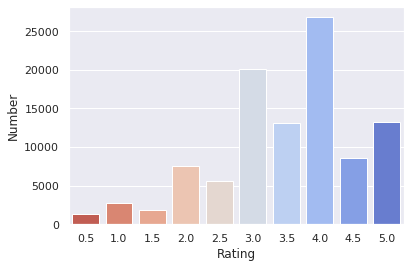

In [6]:
sns.set()
sns.barplot(x='Rating', y='Number', data=total_ratings, palette='coolwarm_r')

These results are very interesting. I expected a more typical bell curve, centered about a 3 star rating as opposed to 4. It seems users are much more likely to give a whole-number rating. As for why most reviews are positive, this is perhaps a result of users only rating movies they watch, and only watching movies they think they will enjoy, thus biasing the system toward positive reviews. This is, of course, completely speculative.

Does genre have any effect on the rating distribution? Let's find out.

In [7]:
genre_ratings = {}
for genre in genres:
    genre_ratings[genre] = [0,0,0,0,0,0,0,0,0,0]
    
for (_, rating_row) in ratings.iterrows():
    for(_, movie_row) in movies[movies['movieId'] == rating_row['movieId']].iterrows():
        for genre in genres:
            if movie_row[genre] == 1:
                genre_ratings[genre][int(rating_row['rating']*2-1)] += 1

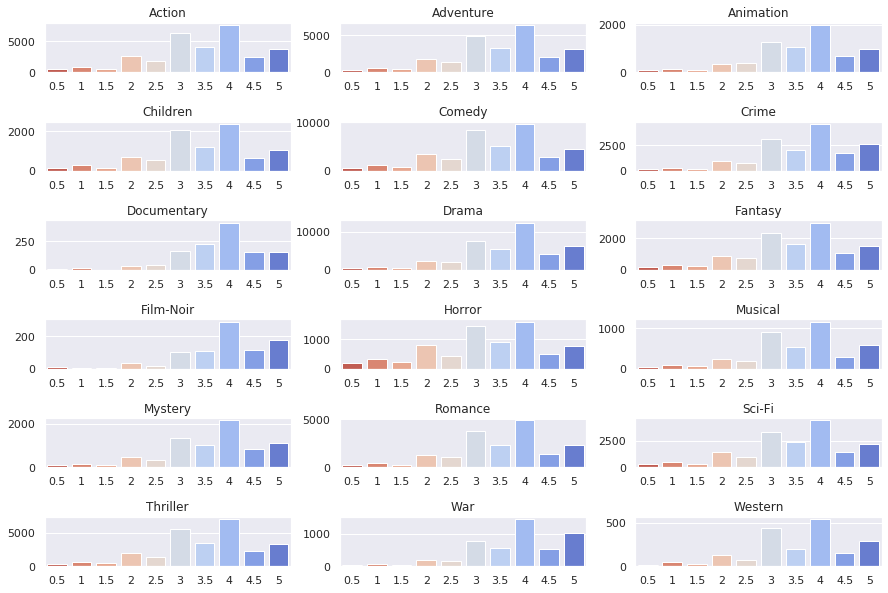

In [8]:
genre_ratings_df = pd.DataFrame(genre_ratings)
genre_ratings_df['Rating'] = ['0.5', '1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5']

sns.set(rc={'figure.figsize':(15,10)})
fig, ax = plt.subplots(6,3)
fig.subplots_adjust(hspace=1)
for idx, genre in enumerate(genres):
    plot = sns.barplot(x='Rating', y=genre, data=genre_ratings_df, palette='coolwarm_r', ax=ax.flatten()[idx])
    plot.set(title=genre, ylabel='', xlabel='')

The genre-specific graphs largely reflect the general distribution, with some interesting exceptions. It appears some genres are more immune than others to low ratings. For example, horror movies have a much greater ratio of negative reviews than other genres. We see documentaries and film-noir have very little negative reviews, but the total number of reviews is quite small, so we shouldn't put too much stock into that. More impressive is the drama category, which appears to have the most number of reviews, while also mainting very few negative ratings.

Before moving on from the genre perspective, let's quickly compare the average ratings per genre.

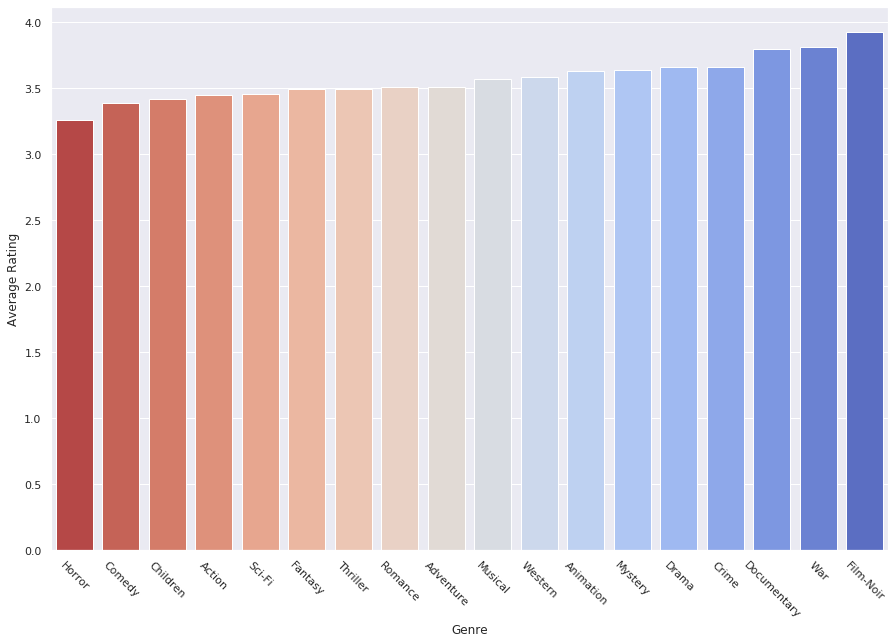

In [49]:
def get_genre_avg(g):
    def weight_rating(p):
        (x,y) = p
        return y*(x/2+.5)
    return sum(map(weight_rating, enumerate(genre_ratings[g])))/sum(genre_ratings[g])
    
genre_avg = pd.DataFrame()
genre_avg['Genre'] = genres
genre_avg['Average Rating'] = list(map(get_genre_avg, genres))

genre_avg = genre_avg.sort_values(by=['Average Rating'])

sns.set()
fig, ax = plt.subplots()
foo = sns.barplot(x='Genre', y='Average Rating', data=genre_avg, palette='coolwarm_r', ax=ax)
_ = foo.set_xticklabels(ax.get_xticklabels(),rotation=-45)

This is great, except it ommits our previous observation that some genres have vastly different number of ratings than others. The average ratings of sparse genres should be met with some skepticism. The following graph adds a confidence interval based on the number of samples. It also stretches the y-axis so that the confidence interval is more visible.

In [55]:
all_ratings_with_genre = pd.DataFrame(columns=['Rating', 'Genre'])

for _, rating_row in ratings.iterrows():
    for(_, movie_row) in movies[movies['movieId'] == rating_row['movieId']].iterrows():
        for genre in genres:
            if movie_row[genre] == 1:
                all_ratings_with_genre = all_ratings_with_genre.append({'Rating': rating_row['rating'], 'Genre': genre}, ignore_index=True)

,Rating,Genre
0,4.0,Adventure
1,4.0,Animation
2,4.0,Children
3,4.0,Comedy
4,4.0,Fantasy
...,...,...
270283,5.0,Sci-Fi
270284,3.0,Action
270285,3.0,Crime
270286,3.0,Drama


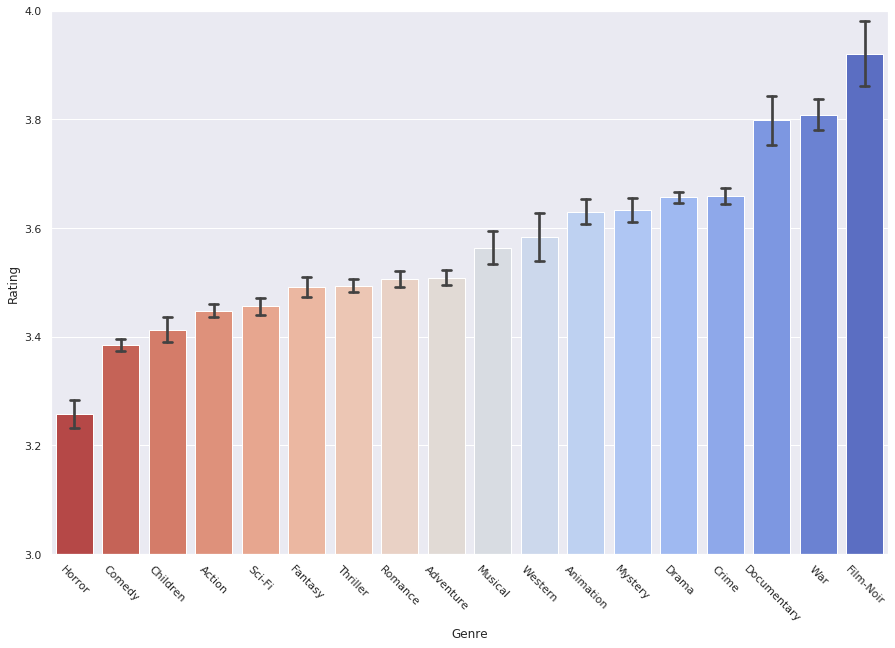

In [67]:
fig, ax = plt.subplots()
foo = sns.barplot(x='Genre', y='Rating', data=all_ratings_with_genre, palette='coolwarm_r', ax=ax, capsize=.2,
                  order=['Horror','Comedy','Children','Action','Sci-Fi','Fantasy','Thriller','Romance','Adventure',
                         'Musical','Western','Animation','Mystery','Drama','Crime','Documentary','War','Film-Noir'])
plt.ylim(3, 4)
_ = foo.set_xticklabels(ax.get_xticklabels(),rotation=-45)

Here, we see that the genres at both extremes of average rating also have some of the largest confidence intervals. I believe, with more reviews, all of the genres would gravitate closer together.

The last thing I'd like to look at are the user supplied tags. I'll use a portion of the larger variant since our analysis won't be *too* computational.

In [140]:
# tags = pd.read_csv('../data/ml-latest-small/tags.csv')
tags = pd.read_csv('../data/ml-20m/tags.csv')
tags = tags.dropna()
tags = tags.sample(frac =.33)
tags['tag'] = tags['tag'].apply(lambda s: s.strip().title())
tags.head()

,userId,movieId,tag,timestamp
242852,70201,119595,Albert Pyun,1419667692
352177,107925,6377,Funny,1302441649
400004,123297,4442,Betamax,1230593589
222216,68167,4974,Stupid,1368678875
343236,104059,7153,Tolkien,1179431989


In [141]:
tags['tag'].describe()

count     153631
unique     19740
top       Sci-Fi
freq        1174
Name: tag, dtype: object

These tags are extremely diverse, and the nonnumerical nature of the data make it difficult to get any sort of intution for this dataset. I think visualizing with a word cloud would allow one to get a sense of the distribution of popular tags.

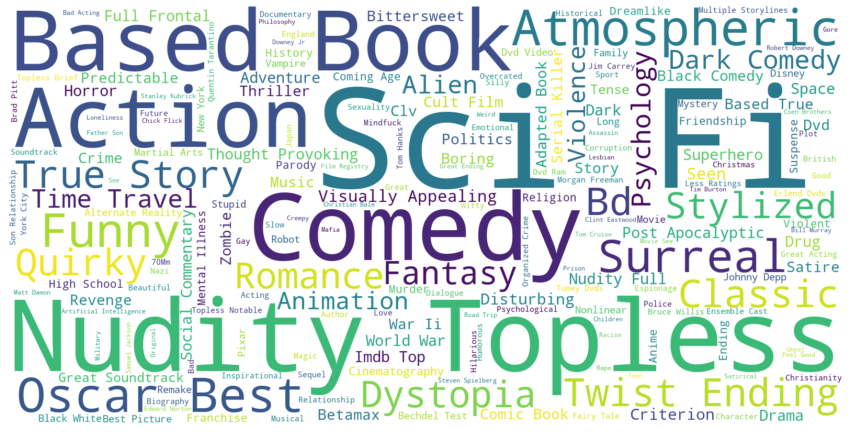

In [142]:
all_tags_text = functools.reduce(lambda x, y: x+' '+y, tags['tag'].values)
wordcloud = wc.WordCloud(background_color='white', width=1600, height=800).generate(all_tags_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Some takeaways. First of all, a surprising number of the tags center around nudity. I'll just assume these are here so that responsible parents can judge whether a movie is appropriate for their children.

Second, many of the most popular tags are just genres. "Sci Fi" is the biggest tag, with "Comedy" and "Action" also taking up quite a lot of space. Perhaps these tags are made by users who feel a movie is inadequately categorized, e.g. voting comedy on a movie labeled only as a drama.

Beyond that, most tags seem helpful and descriptive, e.g. "Stylized", "Surreal", "Atmospheric", "Dystopia". There are also quite a few tags of famous actors, presumably the leading actors.

## Conclusion

In this notebook, I decided to explore the MovieLens dataset due to its size and the diversity of its data. I started by investigating the rating distribution across every movie using a bar plot, and then doing the same to each individual genre to compare. Then, I compared average ratings across genres, again using bar plots, and incorporating a certainty interval to visualize our confidence in the averages given the varying number of total ratings per genre. Finally, I turned my attention to the "tag" data - short, user supplied phrases describing the movie. This data was tricky to visualize given its nonnumerical nature. I decided to use a word cloud to hopefully provide an intuition of the distribution and common characteristics of tags.

I believe the visualizations were vital in discovering patterns in this dataset that I did not see in my first expedition through it.